In [1]:
import pandas as pd
from biodatatools.utils.common import json_load
from mphelper import ProcessWrapPool
import seaborn as sns
from collections import defaultdict, Counter
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pybedtools
import itertools
import biodataplot.metaplot as bpm
from biodata.bigwig import BigWigIReader
from biodata.bed import BEDXReader
from genomictools import GenomicCollection
from statannotations.Annotator import Annotator
from pathlib import Path
import sys

In [23]:
font_dir = Path.cwd().parent / "font"
for font in ["Arial.ttf", "Arial_Bold.ttf"]:
    matplotlib.font_manager.fontManager.addfont(font_dir / font)
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9
lw = 0.8

In [2]:
sys.path.append(str(Path.cwd().parent))
import utils

In [3]:
PROJECT_DIR_d = "/fs/cbsuhy02/storage/yc2553/yc2553/databases/"
PROJECT_DIR_d2 = "/home/yc2553/projects/HEA/databases/"
PROJECT_DIR_d3 = "/home/yc2553/databases/PE/"
PROJECT_DIR_r = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/"
PROJECT_DIR_o = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/output/"
PROJECT_DIR_o2 = "/home/yc2553/projects/HEA/output/"

# Evo metrics

## Get matrix

In [15]:
p = "divergent"
ds = ["distal", "proximal"]
clades = json_load(f"{PROJECT_DIR_r}other/age/clades.json")

In [16]:
df_features = {}

In [17]:
m = "Age"
for d in ds:
    inputfile = f"{PROJECT_DIR_o}temp/{p}_{d}_age.bed"
    df_features[(m,p,d)] = utils.age_dissection(inputfile, clades)

In [18]:
bws = {"phyloP": f"{PROJECT_DIR_d}UCSC/phyloP/hg38/hg38.phyloP447way.bw",
       "CDTS": f"{PROJECT_DIR_r}other/CDTS/coord_CDTS_percentile_N7794unrelated.bw"
        }

In [20]:
use_strand = False
for d in ds:
    bed = f"{PROJECT_DIR_d2}PROcap/processed/merged_{p}_{d}.bed.bgz"
    all_regions = BEDXReader.read_all(GenomicCollection, bed)
    index = [f"{r.chrom}_{r.chromStart}_{r.chromEnd}" for r in all_regions]
    for m in bws:
        df_features[(m,p,d)] = pd.DataFrame(bpm.generate_signal_profile(all_regions, BigWigIReader(bws[m]), fixed_size=1001, use_strand=use_strand), index=index)

In [21]:
df_reformat = {}
for k in df_features:
    df = df_features[k].reset_index()
    df_reformat[k] = pd.melt(df,
                          id_vars="index",
                          value_vars=list(df.columns[1:]),
                          var_name="Position",
                          value_name="Feature"
                          )

## Metaplots

In [8]:
ms = ["Age", "phyloP", "CDTS"]
ptypes = ["P-P", "P-B", "B-B"]

In [9]:
labels = json_load(f"{PROJECT_DIR_d2}PROcap/metainfo/classifications.json")

In [10]:
inputfile = f"{PROJECT_DIR_d2}PROcap/metainfo/keep_samples.txt"
samples = list(pd.read_table(inputfile, header=None)[0])
len(samples)

93

In [11]:
tissues = defaultdict(list)
for s in samples:
	tissues["_".join(labels[s][1].split(" "))].append(s)
len(tissues)

15

In [12]:
def get_df_metaplots(df_reformat, t, ptypes):
	df_metaplots = {}
	for k in df_reformat:
		m, p, d = k
		dfs = []
		for pt in ptypes:
			b = pybedtools.BedTool(f"{PROJECT_DIR_o2}shape/{t}_{d}_{pt}.bed")
			es = ["_".join(i.fields[:3]) for i in b]
			df = df_reformat[k][df_reformat[k]["index"].isin(es)].copy()
			df["Label"] = pt
			dfs.append(df)
		df_metaplots[(m,p,d)] = pd.concat(dfs).reset_index(drop=True)
	return df_metaplots

In [13]:
def generate_metaplot(ms, ds, df_reformat, t, ptypes, outputfile=None, test=True):
	df_metaplots = get_df_metaplots(df_reformat, t, ptypes)
	
	fig, axes = plt.subplots(len(ms), len(ds), figsize=(2.5,2.5))
	for m, d in itertools.product(ms, ds):
		row = ms.index(m)
		col = ds.index(d)
		
		df = df_metaplots[(m,p,d)]
		if test:
			frames = []
			for n in range(len(ptypes)):
				frames.append(df[df["Label"]==ptypes[n]].head(10))
			df = pd.concat(frames)
		g = sns.lineplot(df, x="Position", y="Feature", palette=["#80b1d3", "#bc80bd", "#fb8072"], 
							 hue="Label", hue_order=ptypes, errorbar=None, ax=axes[row, col])

		# Used to create a separate legend for the combined figure
		handles, labels = g.get_legend_handles_labels()
	
		if col == 0:
			g.set_ylabel(m, fontsize=sfontsize)
		else:
			g.set_ylabel("")	
		g.get_yaxis().set_label_coords(-0.4, 0.5)
		
		g.set_xticks([0, 500, 1000])
		if row == len(ms)-1:
			g.set_xticklabels([-0.5, 0, 0.5])
			g.set_xlabel("Distance (kb)", fontsize=sfontsize)
		else:
			g.set_xticklabels([])
			g.set_xlabel("")

		g.tick_params(labelsize=7)
		
		if row == 0:
			g.set_title(d.capitalize(), fontsize=sfontsize)

		g.legend([],[], frameon=False)
			
	fig.subplots_adjust(wspace=0.5, hspace=0.15)
	if outputfile:
		plt.savefig(outputfile, bbox_inches='tight', dpi=300, transparent=True)
	else:
		plt.close()
	
	return handles, labels

In [25]:
pwpool = ProcessWrapPool(10)

# test = True
test = False
for t in tissues:
	outputfile = f"{PROJECT_DIR_o2}figures/SuppFig7_{t}.png"
	pwpool.run(generate_metaplot, args=[ms, ds, df_reformat, t, ptypes, outputfile, test])

In [49]:
len(pwpool.finished_tasks)

15

In [50]:
pwpool.close()

In [26]:
handles, labels = generate_metaplot(ms, ds, df_reformat, t, ptypes, test=True)

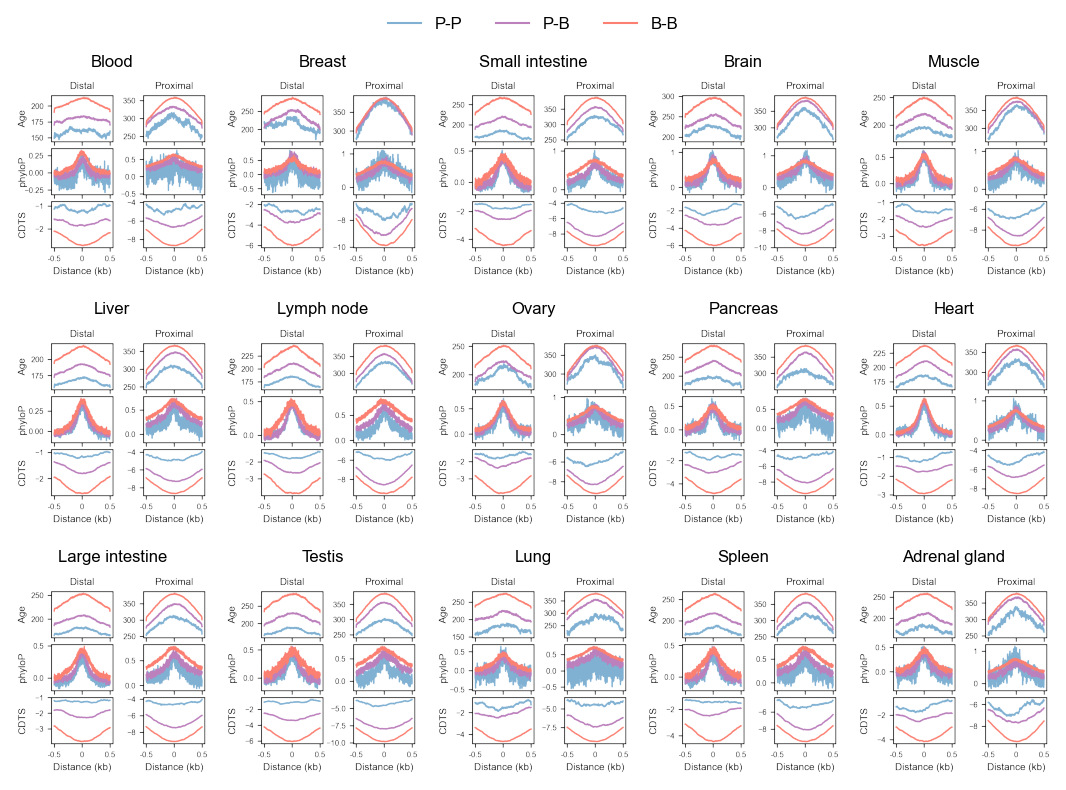

In [27]:
# Display all tissues

nrow = 3
ncol = 5
fig, axes = plt.subplots(nrow,ncol,figsize=(13.5,9.5))
for t in tissues:
	row = list(tissues).index(t)//ncol
	col = list(tissues).index(t)%ncol
	img = mpimg.imread(f"{PROJECT_DIR_o2}figures/SuppFig7_{t}.png")
	axes[row, col].imshow(img)
	axes[row, col].set_title(" ".join(t.split("_")), fontsize=bfontsize)
	axes[row, col].axis('off') 
	if row == 0 and col == 2:
		axes[row, col].legend(handles, labels, title="", frameon=False, fontsize=bfontsize,
							  loc="upper center", ncols=3, bbox_to_anchor=(0.5,1.35))
fig.subplots_adjust(wspace=0.03, hspace=0.05)
fig.savefig(f"{PROJECT_DIR_o2}figures/SuppFig7.png", bbox_inches="tight", transparent=True, dpi=300)

# P-E links

In [28]:
inputfile = f"{PROJECT_DIR_o2}tables/SuppTable2.xlsx"
df_e2g = pd.read_excel(inputfile, sheet_name="PE_links")
df_e2g.head(2)

,Tissue type,Thresholded element gene links,Element gene links
0,Breast,ENCFF502MYU,ENCFF889APJ
1,Small_intestine,ENCFF618HVK,ENCFF201ICX


In [30]:
ENCODE_IDs = {}
for _, row in df_e2g.iterrows():
    for output in df_e2g.columns[1:]:
        ENCODE_IDs[(row["Tissue type"], output)] = row[output]

In [32]:
def get_es_mapping(t, PE_file, ptypes):
    # PRO-cap elements --> E2G elements
    es_mapping = defaultdict(dict)
    b1 = pybedtools.BedTool(PE_file)
    # Seems extra TAB in some files; just use the first three columns
    b1_trimmed = b1.cut([0, 1, 2])
    for d, pt in itertools.product(ds, ptypes):
        b2 = pybedtools.BedTool(f"{PROJECT_DIR_o2}shape/{t}_{d}_{pt}.bed")
        overlaps = b2.intersect(b1_trimmed, wao=True)
        for i in overlaps:
            if int(i.fields[-1]) > 0:
                e1 = "_".join(i.fields[:3])
                e2 = "_".join(i.fields[3:6])
                overlap = int(i.fields[-1])
                if e1 not in es_mapping[d]:
                    es_mapping[d][e1] = (e2, overlap)
                elif overlap > es_mapping[d][e1][1]:
                    es_mapping[d][e1] = (e2, overlap)
    return es_mapping

In [33]:
def get_promoters(PE_file):
    df = pd.read_table(PE_file)
    df = df[df["isSelfPromoter"] == True].copy()
    df['element'] = df['#chr'].astype(str) + '_' + df['start'].astype(str) + '_' + df['end'].astype(str)
    return dict(zip(df['element'], df['TargetGene']))

In [34]:
def get_PE_links(PE_file):
    # Get target genes of each enhancer
    e2g = defaultdict(set)
    # Get enhancers of each genes
    g2e = defaultdict(set)
    
    df_PE = pd.read_table(PE_file)
    for _, row in df_PE.iterrows():
        e = "_".join([row["#chr"], str(row["start"]), str(row["end"])])
        if not row["isSelfPromoter"]:
            e2g[e].add(row["TargetGene"])
            g2e[row["TargetGene"]].add(e)
            
    return e2g, g2e

In [35]:
def get_n_links(t, PE_file1, PE_file2, ptypes):
    # Map PRO-cap elements to E2G/ABC elements
    es_mapping = get_es_mapping(t, PE_file1, ptypes)
    # Assign promoters to genes
    promoters = get_promoters(PE_file1)
    # Get PE links
    e2g, g2e = get_PE_links(PE_file2)

    shapes = {}
    for d, pt in itertools.product(ds, ptypes):
        b = pybedtools.BedTool(f"{PROJECT_DIR_o2}shape/{t}_{d}_{pt}.bed")
        shapes[(d, pt)] = ["_".join(i.fields[:3]) for i in b]

    d = "distal"
    results = []
    for pt in ptypes:
        for e in shapes[(d, pt)]:
            if e in es_mapping[d]:
                e2 = es_mapping[d][e][0]
                if e2 in e2g:
                    results.append([t, pt, len(e2g[e2])])
                else:
                    results.append([t, pt, 0])
    df_n_genes = pd.DataFrame(results, columns=["tissue", "type", "n_genes"])

    d = "proximal"
    results = []
    for pt in ptypes:
        for e in shapes[(d, pt)]:
            if e in es_mapping[d]:
                e2 = es_mapping[d][e][0]
                if e2 in promoters:
                    g = promoters[e2]
                    if g in g2e:
                        results.append([t, pt, len(g2e[g])])
                    else:
                        results.append([t, pt, 0])
    df_n_es = pd.DataFrame(results, columns=["tissue", "type", "n_enhancers"])
    
    return df_n_genes, df_n_es

In [36]:
tissues2 = list(df_e2g["Tissue type"])

In [41]:
pwpool = ProcessWrapPool(10)

map_dict = {}
for t in tissues2:
	PE_file1 = f"{PROJECT_DIR_d2}ENCODE/PE/{ENCODE_IDs[(t, 'Element gene links')]}.bed.gz"
	PE_file2 = f"{PROJECT_DIR_d2}ENCODE/PE/{ENCODE_IDs[(t, 'Thresholded element gene links')]}.bed.gz"
	map_dict[t] = pwpool.run(get_n_links, args=[t, PE_file1, PE_file2, ptypes])

In [46]:
len(pwpool.finished_tasks)

12

In [47]:
temp = pwpool.get()

In [48]:
df_n_genes = {}
df_n_es = {}
for k in map_dict:
    df_n_genes[k], df_n_es[k] = temp[map_dict[k]]

In [ ]:
pwpool.close()

In [49]:
def plot_n_links(data, ax, y, ylabel, plot_ylabel=True, title=None, order=ptypes, palette=["#80b1d3", "#bc80bd", "#fb8072"], outputfile=None):
    hue_plot_params = {"data": data,
                        "x": "type",
                        "y": y,
                        "order": order,
                        "palette": palette,
                        "hue": "type",
                        "hue_order": order,
                        "cut": 0
                        }
    g = sns.violinplot(ax=ax, **hue_plot_params)
    g.set_title(title, fontsize=bfontsize)
    g.spines[["top", "right"]].set_visible(False)
    
    if plot_ylabel:
        g.set_ylabel(ylabel, fontsize=bfontsize)
    else:
        g.set_ylabel("")
    g.tick_params(axis="y", labelsize=sfontsize)
    
    g.set_xlabel("")
    g.tick_params(axis="x", labelsize=bfontsize)
    
    pairs = []
    if len(order) == 2:
        pairs = [order]
    else:
        for id1 in range(1, len(order)):
            pairs.append([order[id1-1], order[id1]])
    annotator = Annotator(g, pairs, **hue_plot_params)
    annotator.configure(test="Mann-Whitney", comparisons_correction="BH", text_offset=1, 
                        line_width=lw, text_format="star", verbose=False)
    _, results = annotator.apply_and_annotate()

    if outputfile:
        fig.savefig(outputfile, bbox_inches="tight", transparent=True)

In [61]:
def plot_all_tissues(data, outputfile, y="n_genes", ylabel="No. genes", nrow=3, ncol=4, order=ptypes, palette=["#80b1d3", "#bc80bd", "#fb8072"]):   
    fig, axes = plt.subplots(nrow, ncol, figsize=(9,5.5))
    for t in tissues2:
        row = tissues2.index(t)//ncol
        col = tissues2.index(t)%ncol
        plot_ylabel = True if col == 0 else False
        plot_n_links(data[t], axes[row, col], y, ylabel, plot_ylabel, " ".join(t.split("_")), order, palette)
    
    fig.subplots_adjust(wspace=0.3, hspace=0.7) 
    fig.savefig(outputfile, bbox_inches="tight", transparent=True)

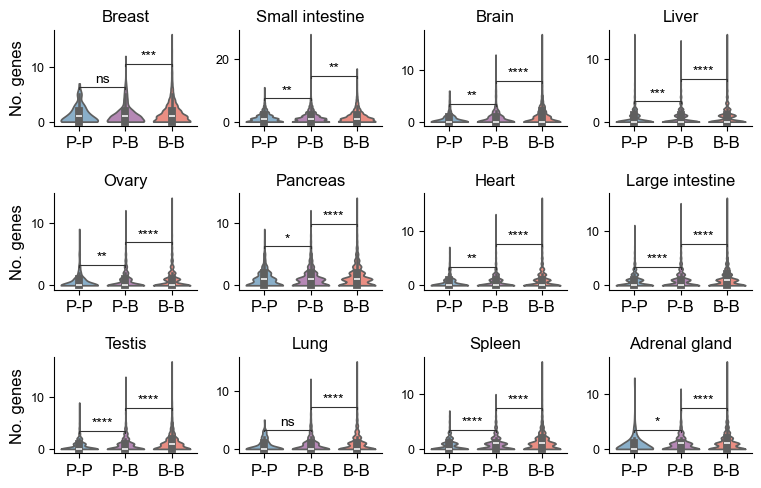

In [62]:
outputfile = f"{PROJECT_DIR_o2}figures/SuppFig8a.pdf"
plot_all_tissues(df_n_genes, outputfile)

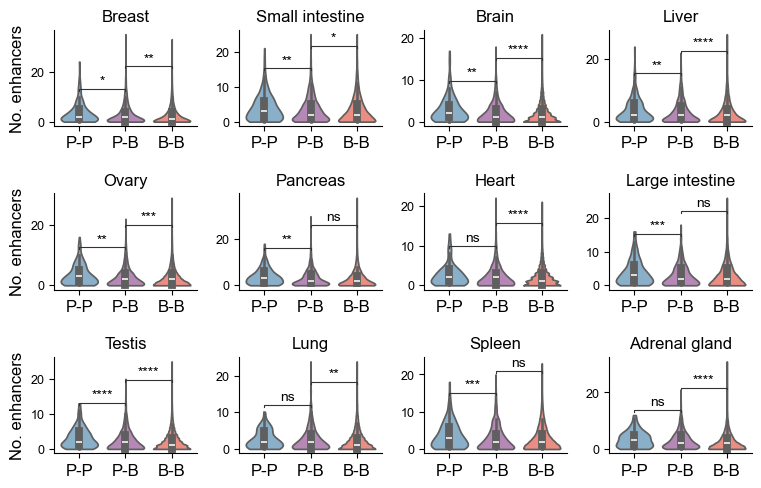

In [63]:
outputfile = f"{PROJECT_DIR_o2}figures/SuppFig8b.pdf"
plot_all_tissues(df_n_es, outputfile, "n_enhancers", "No. enhancers")

In [53]:
# Get mean values for each tissue

dfs = [df_n_genes[t].groupby(["tissue", "type"])["n_genes"].mean().reset_index() for t in df_n_genes]
df_n_genes_all = pd.concat(dfs, ignore_index=True)
df_n_genes_all.head(2)

,tissue,type,n_genes
0,Breast,B-B,1.622982
1,Breast,P-B,1.329044


In [54]:
dfs = [df_n_es[t].groupby(["tissue", "type"])["n_enhancers"].mean().reset_index() for t in df_n_es]
dfs_n_es_all = pd.concat(dfs, ignore_index=True)
dfs_n_es_all.head(2)

,tissue,type,n_enhancers
0,Breast,B-B,2.587933
1,Breast,P-B,2.945521


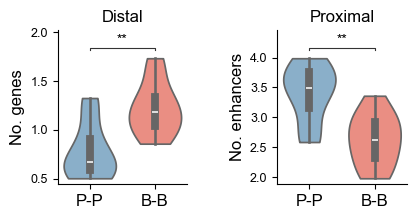

In [60]:
order = ["P-P", "B-B"]
palette = ["#80b1d3", "#fb8072"]
fig, ax = plt.subplots(1, 2, figsize=(4.5,2))
for d in ds:
    col = ds.index(d)
    if d == "distal":
        plot_n_links(df_n_genes_all, ax[col], "n_genes", "No. genes", title=d.capitalize(), order=order, palette=palette)
    else:
        plot_n_links(dfs_n_es_all, ax[col], "n_enhancers", "No. enhancers", title=d.capitalize(), order=order, palette=palette)
fig.subplots_adjust(wspace=0.7) 
fig.savefig(f"{PROJECT_DIR_o2}figures/Fig5e.pdf", bbox_inches="tight", transparent=True)